## Outline of earning outcomes

### Image segmentation methods
1. K-means clustering
2. Anisotropic segmentation
3. Watershed segmentation

## Setup

In [1]:
!pip install requests


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\Acer\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [2]:
import sys
assert sys.version_info >= (3,7)

import numpy as np
import cv2 as cv
from util_func import *

## K-means clustering

- It is a iterative algorithm
- the algoritm will randomly select a point from a cluster (K stands for number of cluster)
- the point will move towards the center of the cluster
- in order to get the centroid, calculate the mean of x and y to get the centroid
- Parameters needed 
    - Number of cluster (user defined, depends on the situation)
    - Stopping criteria (if either one reached, stop)
        - set the maximum number of iteration (default as 10),
        - epsilon (default as 1.0), it is a way to calculate convergence.
    - Number of repitition (default as 10)
    - K-means++ (Better than random)

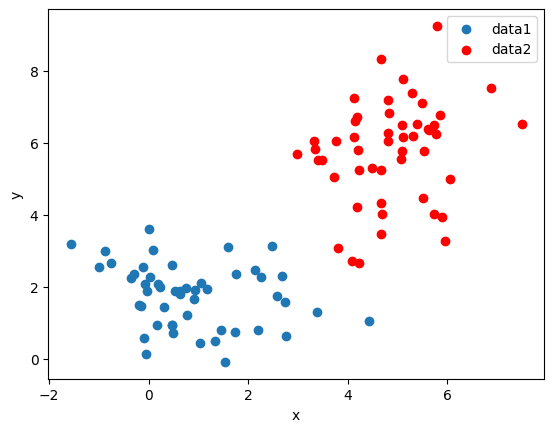

In [3]:
## Generate / sample data points from bivariate (x and y) Gaussian probability distribution
# parameters are mean and covariance(2x2 matrix)

mean1 = (1, 2) # first cluster
cov1 = np.array([[2, 0], [0, 1]]) # want it to be no correlation
dat1 = np.random.multivariate_normal(mean1, cov1, size=50)

mean2 = (5, 6) # second cluster
cov2 = np.array([[1, 0], [0, 2]])
dat2 = np.random.multivariate_normal(mean2, cov2, size=50)

# combine them into a dataset
data = np.concatenate((dat1, dat2), axis=0) # by row
Z = np.float32(data)

plt.scatter(dat1[:, 0], dat1[:, 1], label="data1") # first cluster x and y
plt.scatter(dat2[:, 0], dat2[:, 1], c="r", label="data2")
plt.legend()
plt.xlabel("x"), plt.ylabel("y")
plt.show()

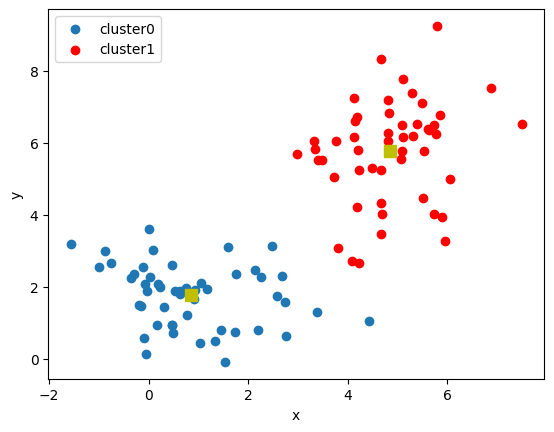

In [4]:
# Apply k-means clustering

criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, 10, 1.0) # 10 max iter, 1.0 eps
ret, label, center = cv.kmeans(Z, 2, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS) # ret is WCSOS

# Subset the cluster
A = Z[label.flatten() == 0]
B = Z[label.flatten() == 1]

plt.scatter(A[:, 0], A[:, 1], label="cluster0") # first cluster x and y
plt.scatter(B[:, 0], B[:, 1], c="r", label="cluster1")
plt.scatter(center[:, 0], center[:, 1], c="y", s=80, marker="s")
plt.legend()
plt.xlabel("x"), plt.ylabel("y")
plt.show()

## How to apply k-means clustering on image?
The key is to reshape.

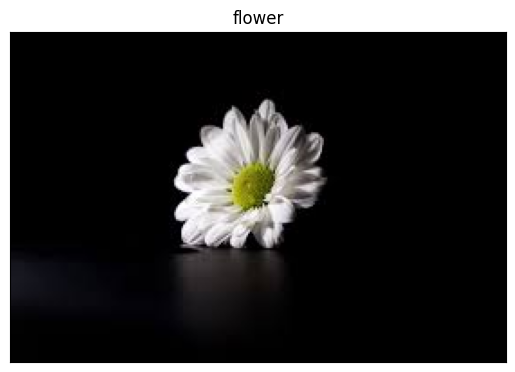

In [5]:
img = cv.imread("images/flower.jfif")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt_img(img_rgb, "flower")

In [6]:
def k_means_clust(img, K, max_iter=10, eps=1.0, attempts=10, flag=cv.KMEANS_PP_CENTERS):
    """
    Args:
    img: 3-channel image array
    K: number of cluster
    By default, max_iter = 10, eps = 1, attempts = 10, k-means++
    """
    # casting and reshape
    img = img.reshape((-1, 3))
    img = np.float32(img)
    criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, max_iter, eps) # 10 max iter, 1.0 eps
    return cv.kmeans(img, K, None, criteria, attempts, flag)

ret, label, center, = k_means_clust(img_rgb, 3)

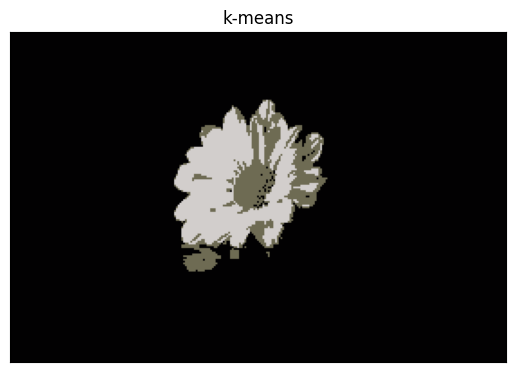

In [7]:
# visualize
# cast to uint8

# doing indexing and propangation
center = np.uint8(center)
res = center[label.flatten()]
# reshape
quant = res.reshape(img_rgb.shape)

plt_img(quant, "k-means")


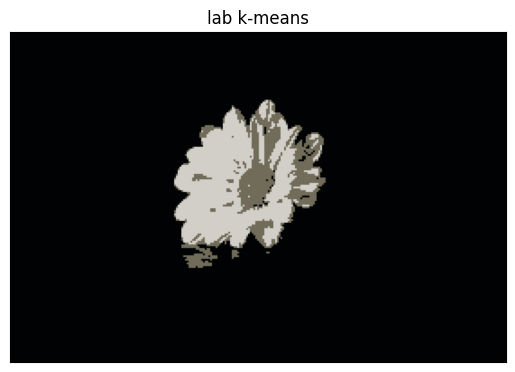

In [8]:
# LAB color space has the property of perceptual uniformity
img_lab =cv.cvtColor(img, cv.COLOR_BGR2Lab)

ret, label, center, = k_means_clust(img_lab, 3)

# doing indexing and propangation
center = np.uint8(center)
res = center[label.flatten()]
# reshape
quant = res.reshape(img_rgb.shape)

quant_rgb = cv.cvtColor(quant, cv.COLOR_Lab2RGB)

plt_img(quant_rgb, "lab k-means")

In [9]:
np.unique(res, axis=0, return_counts=True)

(array([[  1, 128, 127],
        [116, 126, 139],
        [212, 128, 131]], dtype=uint8),
 array([45469,  1781,  3075], dtype=int64))

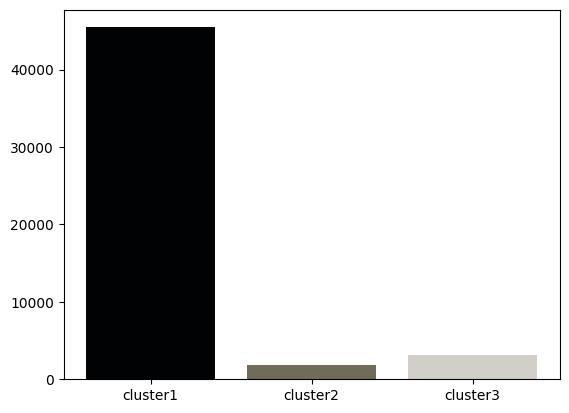

In [10]:
# Make a bar plot for all the cluster
centroids, counts = np.unique(res, axis=0, return_counts=True)

# change lab to rgb
res_rgb = centroids.reshape((3, 1, 3))
res_rgb = cv.cvtColor(res_rgb, cv.COLOR_Lab2RGB)
res_rgb = res_rgb.reshape((3, 3))

# Get the bar plot
xlabel_name = ['cluster'+str(i) for i in range(1,4)]
plt.bar(xlabel_name, counts, color = list(res_rgb/255))
plt.show()

## Anisotropic segmentation


In [11]:
def calcGST(inputIMG, w, method_edge = "scharr"):
    img = np.float32(inputIMG)
    
    # Gradient structure tensor components
    if method_edge == "scharr":        
        imgDiffX = cv.Scharr(img, cv.CV_32F, 1, 0)
        imgDiffY = cv.Scharr(img, cv.CV_32F, 0, 1)
    elif method_edge == "sobel":
        imgDiffX = cv.Sobel(img, cv.CV_32F, 1, 0)
        imgDiffY = cv.Sobel(img, cv.CV_32F, 0, 1)
    else:
        raise Exception("No edge detection method available")
                
    imgDiffXY = cv.multiply(imgDiffX, imgDiffY)
    imgDiffXX = cv.multiply(imgDiffX, imgDiffX)
    imgDiffYY = cv.multiply(imgDiffY, imgDiffY)
    
    J11 = cv.boxFilter(imgDiffXX, cv.CV_32F, (w, w))
    J22 = cv.boxFilter(imgDiffYY, cv.CV_32F, (w, w))
    J12 = cv.boxFilter(imgDiffXY, cv.CV_32F, (w, w))
    
    # eigenvalue
    tmp1 = J11+J22
    tmp2 = J11-J22
    tmp2 = cv.multiply(tmp2, tmp2)
    tmp3 = cv.multiply(J12, J12)
    tmp4 = np.sqrt(tmp2 + 4.0*tmp3)
    
    lambda1 = 0.5*(tmp1+tmp4)
    lambda2 = 0.5*(tmp1 - tmp4)
    
    # coherency
    imgCoherencyOut = cv.divide(lambda1-lambda2, lambda1+lambda2)
    
    # orientation calculation
    imgOrientationOut = cv.phase(J22-J11, 2.0*J12, angleInDegrees = True)
    imgOrientationOut = 0.5*imgOrientationOut
    
    return imgCoherencyOut, imgOrientationOut 

The problem of applying Gaussian filter instead of `cv.boxFilter()` (line 17 to line 19) is numberical stability (division by zero). The way to remedy this issue is by adding the denominatior by a small constant (~10^-6) (line 35).

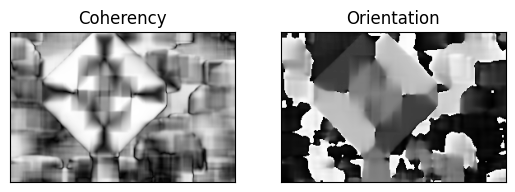

In [12]:
# Display and coherence and orientation map
img = cv.imread("images/traffic_sign.jfif")
blur = cv.GaussianBlur(img, (5, 5), 0)
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

# img = cv.imread("images/road.jpg")
# blur = cv.GaussianBlur(img, (5, 5), 0)
# gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

W = 25
imgCoherency, imgOrientation = calcGST(gray, W)

imgCoherency_norm = cv.normalize(imgCoherency, None, alpha=0, beta=1, 
                                 norm_type = cv.NORM_MINMAX, dtype=cv.CV_32F)
imgOrientation_norm = cv.normalize(imgOrientation, None, alpha=0, beta=1, 
                                 norm_type = cv.NORM_MINMAX, dtype=cv.CV_32F)

plt.subplot(121), plt_img(imgCoherency_norm, "Coherency")
plt.subplot(122), plt_img(imgOrientation_norm, "Orientation")
plt.show()

In [13]:
# Trackbar function
def nothing(x):
    pass

wn = "anisotropic segmentation"
cv.namedWindow(wn, cv.WINDOW_NORMAL + cv.WINDOW_FREERATIO)
cv.createTrackbar("Coherency Threshold 1", wn, 50, 100, nothing)
cv.createTrackbar("Coherency Threshold 2", wn, 70, 100, nothing)
cv.createTrackbar("Orientation Threshold 1", wn, 50, 180, nothing)
cv.createTrackbar("Orientation Threshold 2", wn, 70, 180, nothing)

while True:
    # get trackbar positions
    th_C_1 = cv.getTrackbarPos("Coherency Threshold 1", wn) * 0.01
    th_C_2 = cv.getTrackbarPos("Coherency Threshold 2", wn) * 0.01
    th_Or_1 = cv.getTrackbarPos("Orientation Threshold 1", wn) 
    th_Or_2 = cv.getTrackbarPos("Orientation Threshold 2", wn) 
    
    # thresholding
    imgBin_C_1 = cv.threshold(imgCoherency, th_C_1, 255, cv.THRESH_BINARY)[1]
    imgBin_C_2 = cv.threshold(imgCoherency, th_C_2, 255, cv.THRESH_BINARY_INV)[1]
    imgBin_Or_1 = cv.threshold(imgOrientation, th_Or_1, 255, cv.THRESH_BINARY)[1]
    imgBin_Or_2 = cv.threshold(imgOrientation, th_Or_2, 255, cv.THRESH_BINARY_INV)[1]
    
    imgBin_C = cv.bitwise_and(imgBin_C_1, imgBin_C_2)
    imgBin_Or = cv.bitwise_and(imgBin_Or_1, imgBin_Or_2)
    
    imgBin = cv.bitwise_and(imgBin_C, imgBin_Or)
    
    mask = imgBin != 0  #everything that is not 0 is true
    res = img*(mask[:, :, None].astype(np.uint8))
    cv.imshow("Segmentation",res)

    k = cv.waitKey(1) & 0xFF
    if k==27:
        break
        
cv.destroyAllWindows()

## Watershed segmentation

3 ways to select markers
- Distance transform
- Morphological operations
- Thresholding

-------------------
- Marker: morphological gradient + threshold
- Topographic surface: edge map
(Original color image, Distance transformation, Uses edge detection (canny))
As the input of watershed

-------------------

How to get marker
Image -> Blur -> Mean Shift Segmentation (it suppress noise and quantize images) -> Grayscale
-> Morphological gradient (Getting the outline of the object) -> Threshold (To supress the outline)
-> Connected component labeling -> Output marker

In [14]:
!pip install scikit-image

  Using cached scikit_image-0.21.0-cp311-cp311-win_amd64.whl (22.8 MB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached imageio-2.31.1-py3-none-any.whl (313 kB)
  Using cached lazy_loader-0.3-py3-none-any.whl (9.1 kB)



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\Acer\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [15]:
from skimage.segmentation import watershed
from scipy import ndimage as ndi

In [16]:
# load img
img = cv.imread("images/traffic_sign.jfif")
blur = cv.GaussianBlur(img, (5, 5), 0)
blur = cv.pyrMeanShiftFiltering(blur, 15, 20, maxLevel=2)

show_img("blur", blur)

In [17]:
# grayscale
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

# morphological gradient
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11))
loc_grad = cv.morphologyEx(gray, cv.MORPH_GRADIENT, kernel, iterations=2)

show_img("gradient", loc_grad)

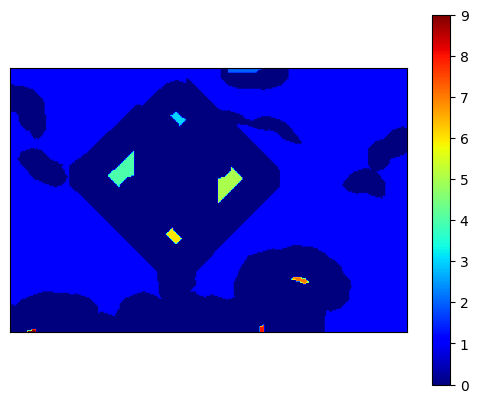

In [18]:
th = loc_grad < 80
# connected component labeling
s = np.ones((3, 3), dtype=int)
marker = ndi.label(th, structure=s)[0]

plt.imshow(marker, cmap=plt.cm.jet)
plt.colorbar()
plt.xticks([]), plt.yticks([])
plt.show()

In [19]:
edge = cv.Canny(gray, 250, 500)

labels = watershed(edge, marker)

In [20]:
np.unique(labels, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([40736,   279,  1234,  2325,  2295,  1270,  1066,   736,   384],
       dtype=int64))

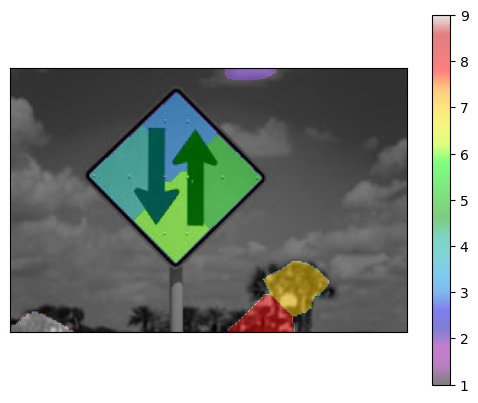

In [21]:
gray_ori = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(gray_ori, cmap="gray")
plt.imshow(labels, cmap=plt.cm.nipy_spectral, alpha=0.5)
plt.colorbar()
plt.xticks([]), plt.yticks([])
plt.show()

In [22]:
# Create mask / binary image and set background to zero.
# assumption: background is always the majority

mask = 255 * np.ones(labels.shape, dtype=np.uint8)

label_vec, counts = np.unique(labels, return_counts=True)
label_bg = label_vec[np.argmax(counts)]

mask[labels==label_bg] = 0

# contours
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# grab the largest contour
contour = sorted(contours, key=cv.contourArea, reverse=True)[0]

img_copy = img.copy()
cv.drawContours(img_copy, [contour], -1, (0, 0, 255), 2)
show_img("contour", img_copy)

In [23]:
# bounding box
img_copy = img.copy()
x, y, w, h = cv.boundingRect(contour)
cv.rectangle(img_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)

show_img("bounding box", img_copy)

In [24]:
img = cv.imread("images/traffic_sign1.jpg")
(h, w) = img.shape[:2]
blur = cv.GaussianBlur(img, (5, 5), 0)

In [25]:
# Convert to Lab
img_lab = cv.cvtColor(blur, cv.COLOR_BGR2Lab)

img_lab = img_lab.reshape((h*w, 3))
img_lab = np.float32(img_lab)
# criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv.KMEANS_PP_CENTERS

compactness, labels, centers = cv.kmeans(img_lab, 10, None, criteria, 10, flags)

quant = centers.astype(np.uint8)[labels]
quant = quant.reshape((h, w, 3))

bgr = cv.cvtColor(quant, cv.COLOR_Lab2BGR)

show_img("kmeans quantization", bgr)

In [26]:
img_lab[..., 0].min()

6.0

In [27]:
gray = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)

th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

show_img("threshold", th)

In [28]:
from skimage.feature import peak_local_max

In [29]:
kernel = np.ones((3, 3), dtype=np.uint8)
th = cv.morphologyEx(th, cv.MORPH_OPEN, kernel, iterations=3)

dist_transform = cv.distanceTransform(th, cv.DIST_L2, 3)

coords = peak_local_max(dist_transform, footprint=np.ones((100, 100)), labels=th)

mask = np.zeros(dist_transform.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-dist_transform, markers, mask=th)

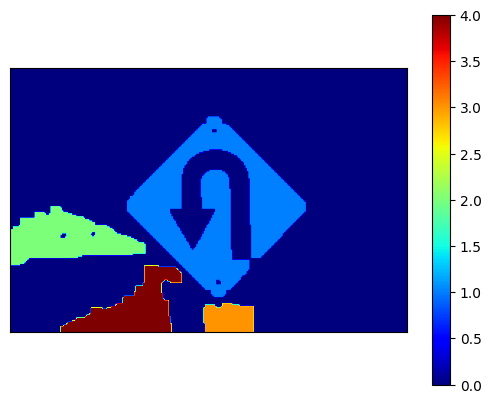

In [30]:
plt.imshow(labels, cmap=plt.cm.jet)
plt.colorbar(), plt.xticks([]), plt.yticks([])
plt.show()

In [31]:
import random as rng
rng.seed(3107)

In [32]:
img = cv.imread("images/cups_coffee.webp")
cv.imshow("source", img)
cv.waitKey(0)
cv.destroyAllWindows()

In [33]:
# change the background to black
# img[np.all(img == 255, axis=2)] = 0
blur = cv.GaussianBlur(img, (7, 7), 0)

# do the Laplacian filter
kernel = np.ones((3, 3), np.float32)
kernel[1, 1] = -8

imgLaplacian = cv.filter2D(blur, cv.CV_32F, kernel)
sharp = np.float32(img)
# The purpose of subtraction is basically to extract the high frequency components
# of an image
imgResult = sharp - imgLaplacian

# convert back to 8 bits
imgResult = np.clip(imgResult, 0, 255)
imgResult = imgResult.astype('uint8')
imgLaplacian = np.clip(imgLaplacian, 0, 255)
imgLaplacian = imgLaplacian.astype('uint8')

cv.imshow("black blackground", img)
cv.imshow('New sharped Image' , imgResult)
cv.imshow('Laplacian', imgLaplacian)
cv.waitKey(0)
cv.destroyAllWindows()

In [34]:
bw = cv.cvtColor(imgResult, cv.COLOR_BGR2GRAY)
_, bw = cv.threshold(bw, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
cv.imshow("binary", bw)
cv.waitKey(0)
cv.destroyAllWindows()

In [35]:
dist = cv.distanceTransform(bw, cv.DIST_L2, 5)

cv.normalize(dist, dist, 0, 1.0, cv.NORM_MINMAX)
cv.imshow("distance transform", dist)
cv.waitKey(0)
cv.destroyAllWindows()

In [36]:
dist = cv.threshold(dist, 0.5, 1.0, cv.THRESH_BINARY)[1]

kernel1 = np.ones((3, 3), dtype=np.uint8)
dist = cv.dilate(dist, kernel1)
cv.imshow("peaks", dist)
cv.waitKey(0)
cv.destroyAllWindows()

In [37]:
dist_8u = dist.astype('uint8')

# find total markers
contours, _ = cv.findContours(dist_8u, cv.RETR_EXTERNAL,
                             cv.CHAIN_APPROX_SIMPLE)
# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)
# Draw the foreground markers
for i in range(len(contours)):
    cv.drawContours(markers, contours, i, (i+1), -1)
# Draw the background marker
# cv.circle(markers, (5,5), 3, (255,255,255), -1)
markers_8u = (markers * 10).astype('uint8')
cv.imshow('Markers', markers_8u)
cv.waitKey(0)
cv.destroyAllWindows()

In [38]:
markers_8u.shape

(495, 660)

In [39]:
cv.watershed(imgResult, markers)
#mark = np.zeros(markers.shape, dtype=np.uint8)
mark = markers.astype('uint8')
mark = cv.bitwise_not(mark)
cv.imshow('Markers', mark)
cv.waitKey(0)
cv.destroyAllWindows()

In [40]:
# Generate random colors
colors = []
for contour in contours:
    colors.append((rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))
# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]
# Visualize the final image
cv.imshow('Final Result', dst)
cv.waitKey(0)
cv.destroyAllWindows()

Weekly Activity

Exercise 1

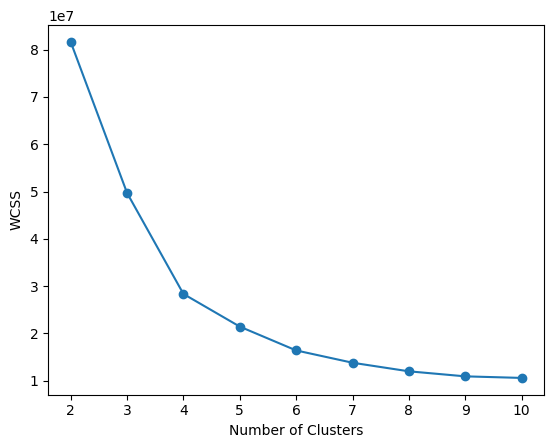

In [42]:
# Determining optimal k

img = cv.imread("images/zebra.jfif")
imgrgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
imgrgb = imgrgb.reshape((-1, 3))

clist = [] # storing sum of squares.
crange = range(2,11) # to get 2-10
Z = np.float32(imgrgb)

for k in crange:
    criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, 10, 1.0) # 10 max iter, 1.0 eps
    ret, label, center = cv.kmeans(Z, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS) # ret is WCSOS
    clist.append(ret)
    
plt.plot(crange, clist, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

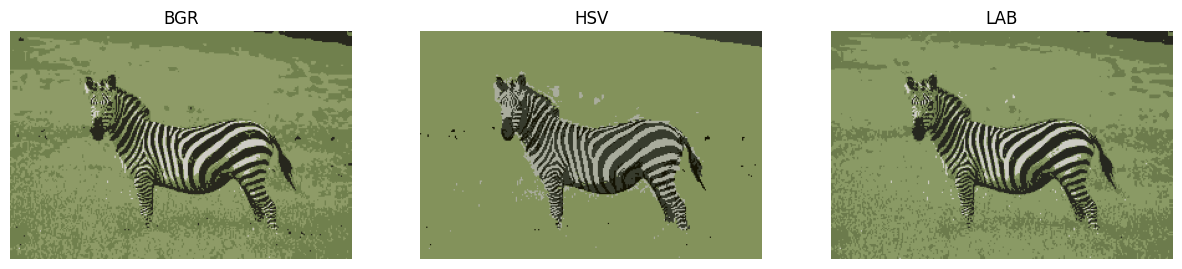

In [65]:
#elbow of the graph is 4
K = 4

# BGR
ret, label, center, = k_means_clust(img, K)

center = np.uint8(center)
res = center[label.flatten()]
quantbgr = res.reshape(img.shape)
quant_bgr = cv.cvtColor(quantbgr, cv.COLOR_BGR2RGB)

# HSV
imghsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

ret, label, center, = k_means_clust(imghsv, K)
center = np.uint8(center)
res = center[label.flatten()]
quanthsv = res.reshape(imghsv.shape)
quant_hsv = cv.cvtColor(quanthsv, cv.COLOR_HSV2RGB)

# LAB
imglab = cv.cvtColor(img, cv.COLOR_BGR2LAB)

ret, label, center, = k_means_clust(imglab, K)
center = np.uint8(center)
res = center[label.flatten()]
quantlab = res.reshape(imglab.shape)
quant_lab = cv.cvtColor(quantlab, cv.COLOR_LAB2RGB)

plt.figure(figsize=(15,4))
plt.subplot(131), plt.imshow(quant_bgr), plt.title("BGR"), plt.axis('off')
# Most detail of the zebra can be seen clearly, however there is some green noises (grass) 
# inside the zebra as BGR might have mixed up similar color pixels together.
plt.subplot(132), plt.imshow(quant_hsv), plt.title("HSV"), plt.axis('off')
# The detail of the zebra may be abit loss, the color may be abit rough and less saturated from the original, no noises in zebra.
# It groups the similar color pixels together such as grasses behind as HUE will categorize similar color together.
plt.subplot(133), plt.imshow(quant_lab), plt.title("LAB"), plt.axis('off')
# Similar to BGR but better, zebra details and shades (lightning on zebra) can be seen clearly, 
# but the noises inside the zebra is more obvious. LAB may be too effective on finding obvious color that causes noises
# in the white stripes of the zebra.

plt.show()